In [6]:
import warnings
warnings.filterwarnings("ignore")
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin


In [7]:
control_1 = pd.read_csv(r"C:\Users\yatha\Documents\Depression\condition\condition_1.csv")
condition_1 = pd.read_csv(r"C:\Users\yatha\Documents\Depression\control\control_1.csv")
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (23244, 3)
condition_1.shape: (51611, 3)


In [8]:
# The dataset contains two folders, whereas one contains the data for the controls and one for the condition group.
#For each patient a csv file has been provided containing the actigraph data collected over time.

# The columns are: timestamp (one minute intervals)

# date (date of measurement)

# activity (activity measurement from the actigraph watch)

# the MADRS scores provided in the file "scores.csv". It contains the following columns

# number (patient identifier)

# days (number of days of measurements)

# gender (1 or 2 for female or male)

# age (age in age groups)

# afftype (1: bipolar II, 2: unipolar depressive, 3: bipolar I)

# melanch (1: melancholia, 2: no melancholia)

# inpatient (1: inpatient, 2: outpatient)

# edu (education grouped in years)

# marriage (1: married or cohabiting, 2: single)

# work (1: working or studying, 2: unemployed/sick leave/pension)

# madrs1 (MADRS score when measurement started)

# madrs2 (MADRS when measurement stopped)

In [9]:
control_1.head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [10]:
condition_1.head()

,timestamp,date,activity
0,2003-03-18 15:00:00,2003-03-18,60
1,2003-03-18 15:01:00,2003-03-18,0
2,2003-03-18 15:02:00,2003-03-18,264
3,2003-03-18 15:03:00,2003-03-18,662
4,2003-03-18 15:04:00,2003-03-18,293


<AxesSubplot:xlabel='activity', ylabel='Count'>

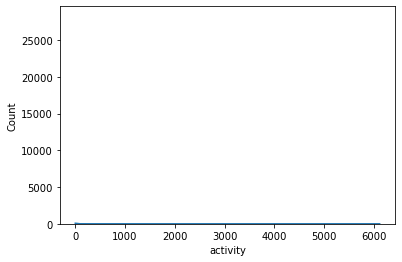

In [11]:
sns.histplot(x='activity', data=condition_1,kde=True)

In [12]:
condition_1['activity'].skew()

5.039169993104665

### From the above graph, it can be seen that there is high level of skewness, An alternative is taking the log or square root of activity

In [13]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # add + 1 because log(0) is infinity
condition_1['log_activity'].skew()

1.2517081703386566

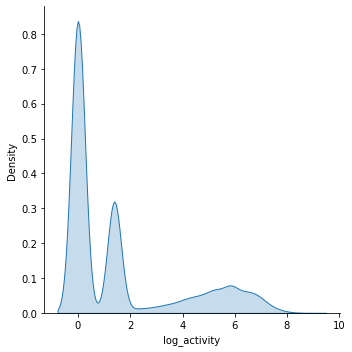

In [14]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)

In [15]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

2.4024647298843784

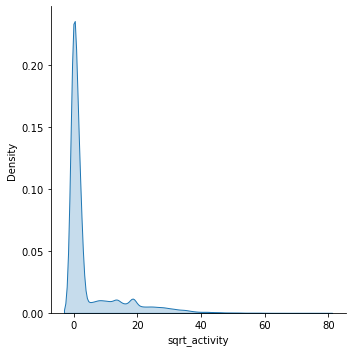

In [16]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)

In [17]:
condition_1.describe()

,activity,log_activity,sqrt_activity
count,51611.000000,51611.000000,51611.000000
mean,98.545078,1.590457,4.571890
std,289.655317,2.280201,8.811606
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,3.000000,1.386294,1.732051
max,6117.000000,8.718991,78.211252


In [18]:
control_1['activity'].skew()

3.8823677090908344

In [19]:
control_1.describe()

,activity
count,23244.000000
mean,146.948030
std,294.592424
min,0.000000
25%,0.000000
50%,9.000000
75%,172.000000
max,3526.000000


In [20]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

0.2771381485812395

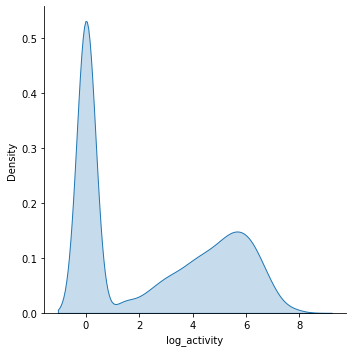

In [21]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True)

In [22]:
condition_1.head()

,timestamp,date,activity,log_activity,sqrt_activity
0,2003-03-18 15:00:00,2003-03-18,60,4.110874,7.745967
1,2003-03-18 15:01:00,2003-03-18,0,0.000000,0.000000
2,2003-03-18 15:02:00,2003-03-18,264,5.579730,16.248077
3,2003-03-18 15:03:00,2003-03-18,662,6.496775,25.729361
4,2003-03-18 15:04:00,2003-03-18,293,5.683580,17.117243


In [23]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

,date,log_activity
0,2003-03-18,4.269175
1,2003-03-19,3.006935
2,2003-03-20,3.220895
3,2003-03-21,2.737783
4,2003-03-22,3.302284


In [24]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df

In [25]:
combine_df=combine_data(string)

In [26]:
string="C:\\Users\\yatha\\Downloads\\archive (6)\\data\\condition\\"

In [27]:
string1="C:\\Users\\yatha\\Downloads\\archive (6)\\data\\control\\"

In [28]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [29]:
combine_df = combine_data(string1)

In [30]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

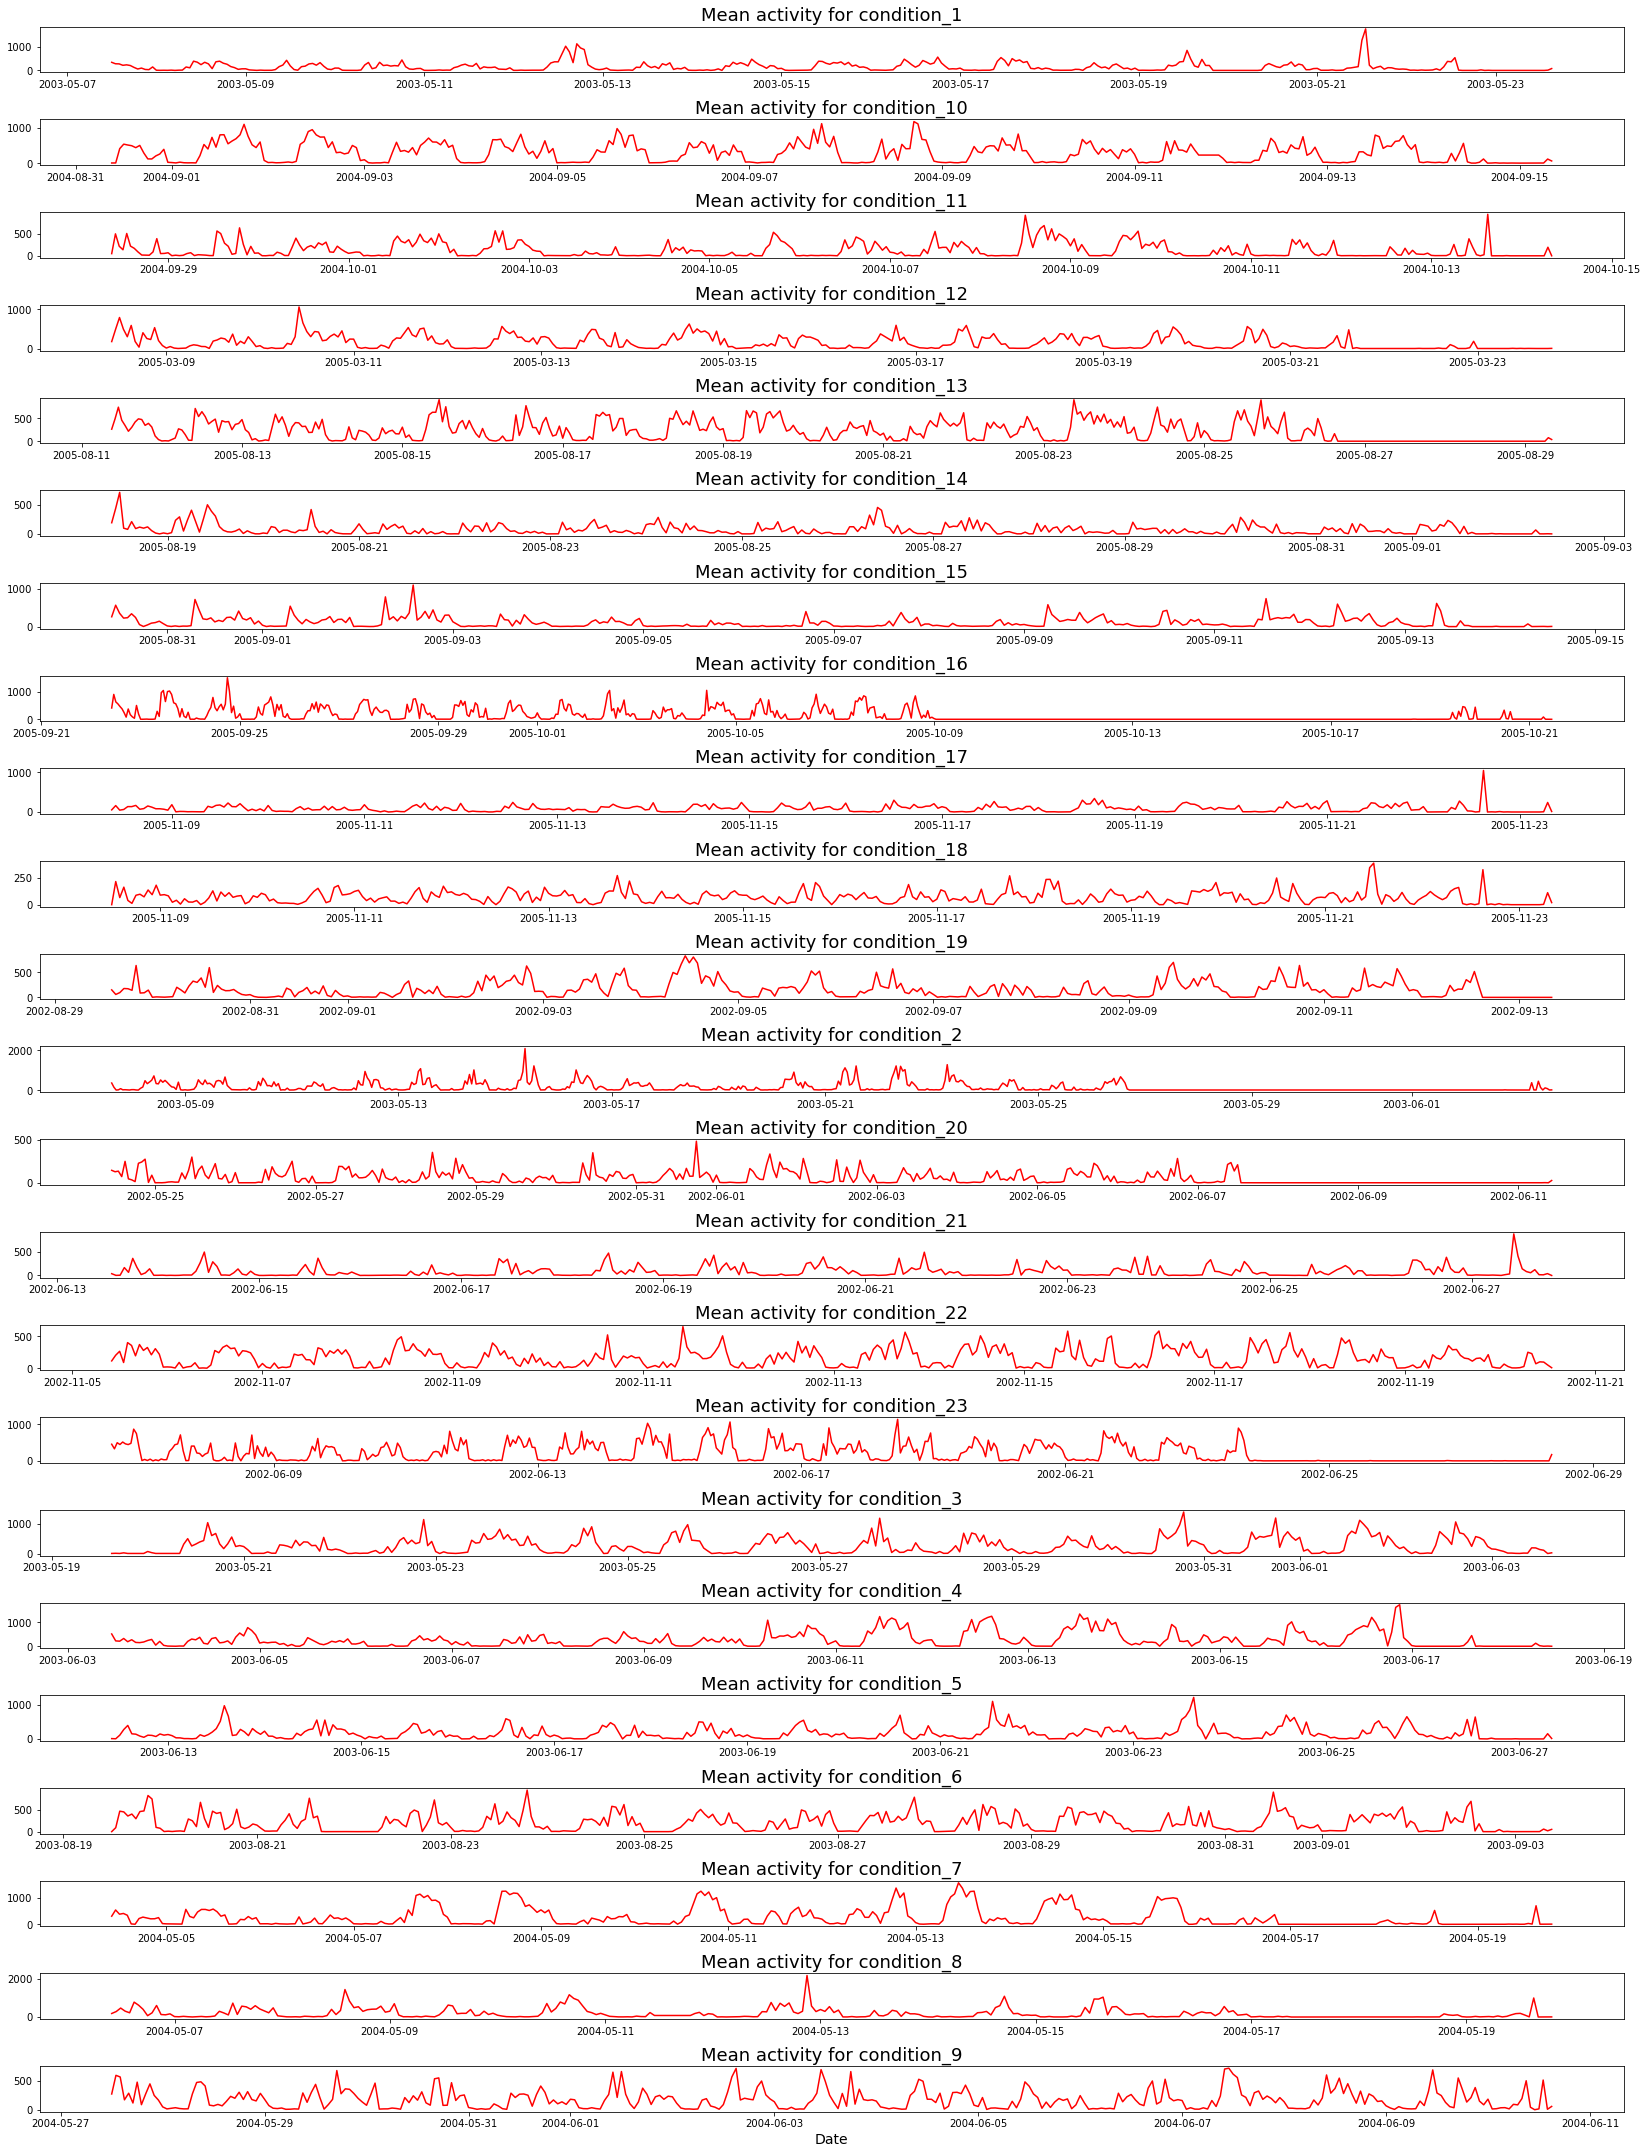

In [31]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

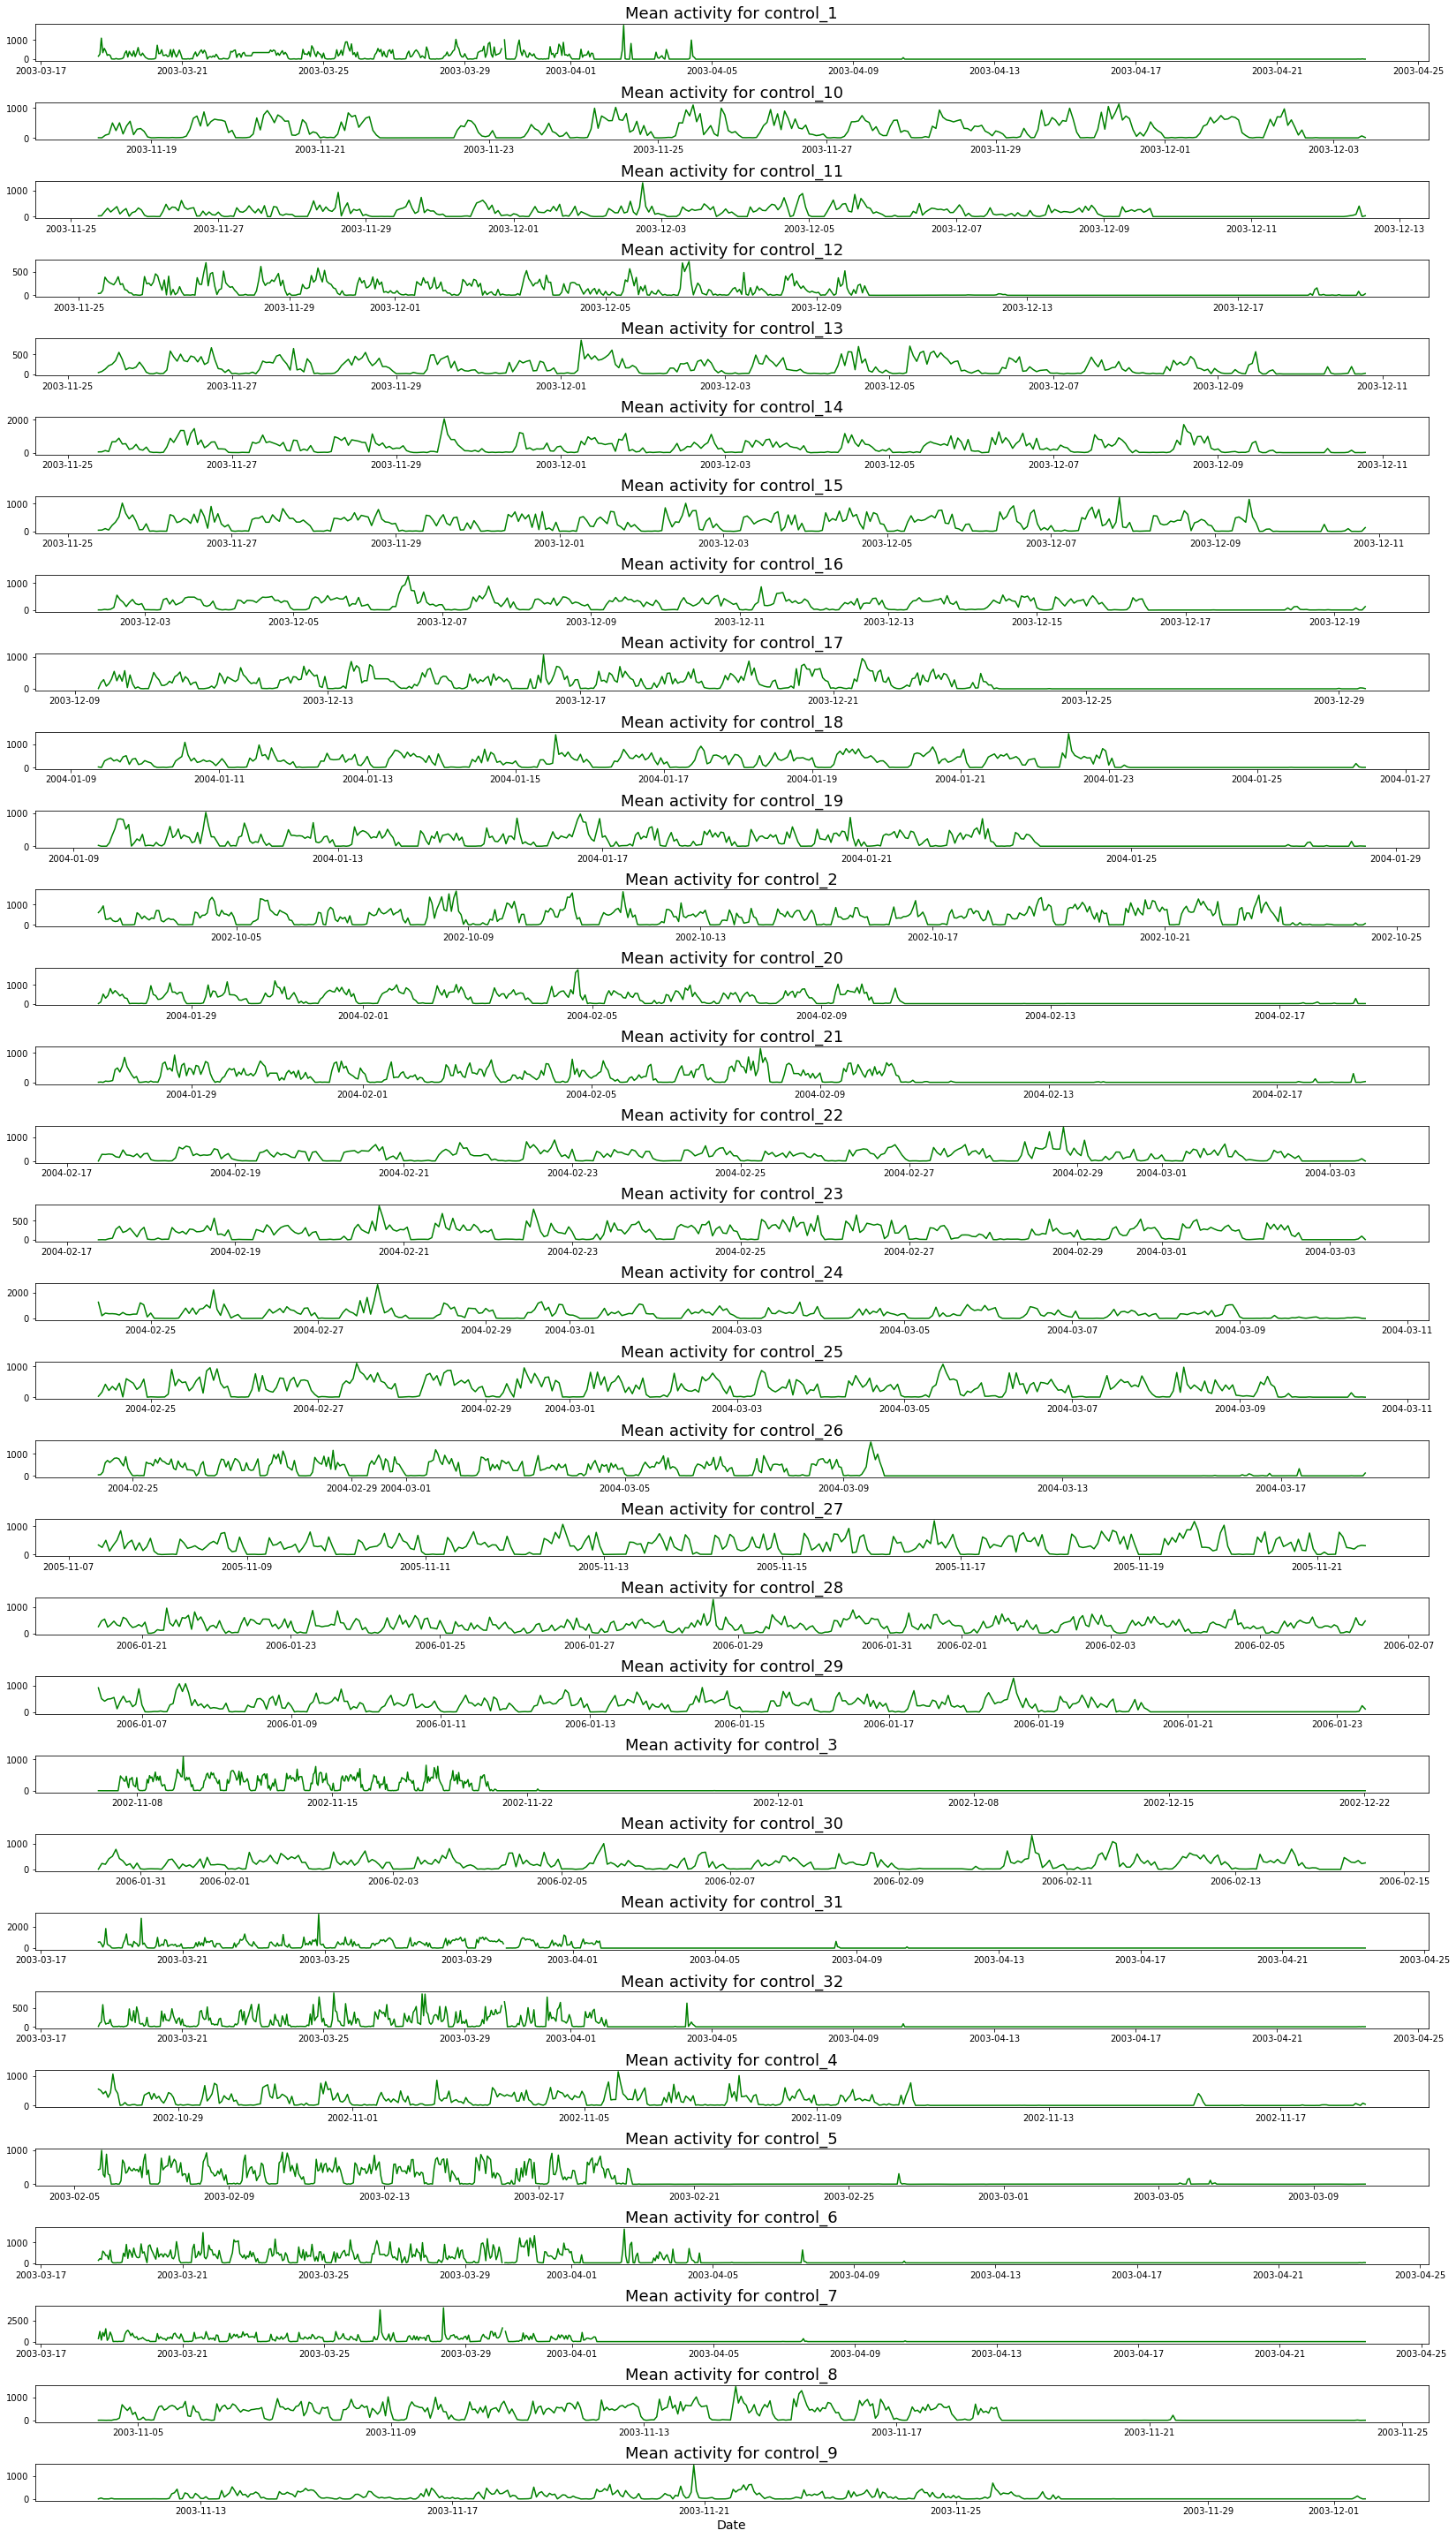

In [32]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [33]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

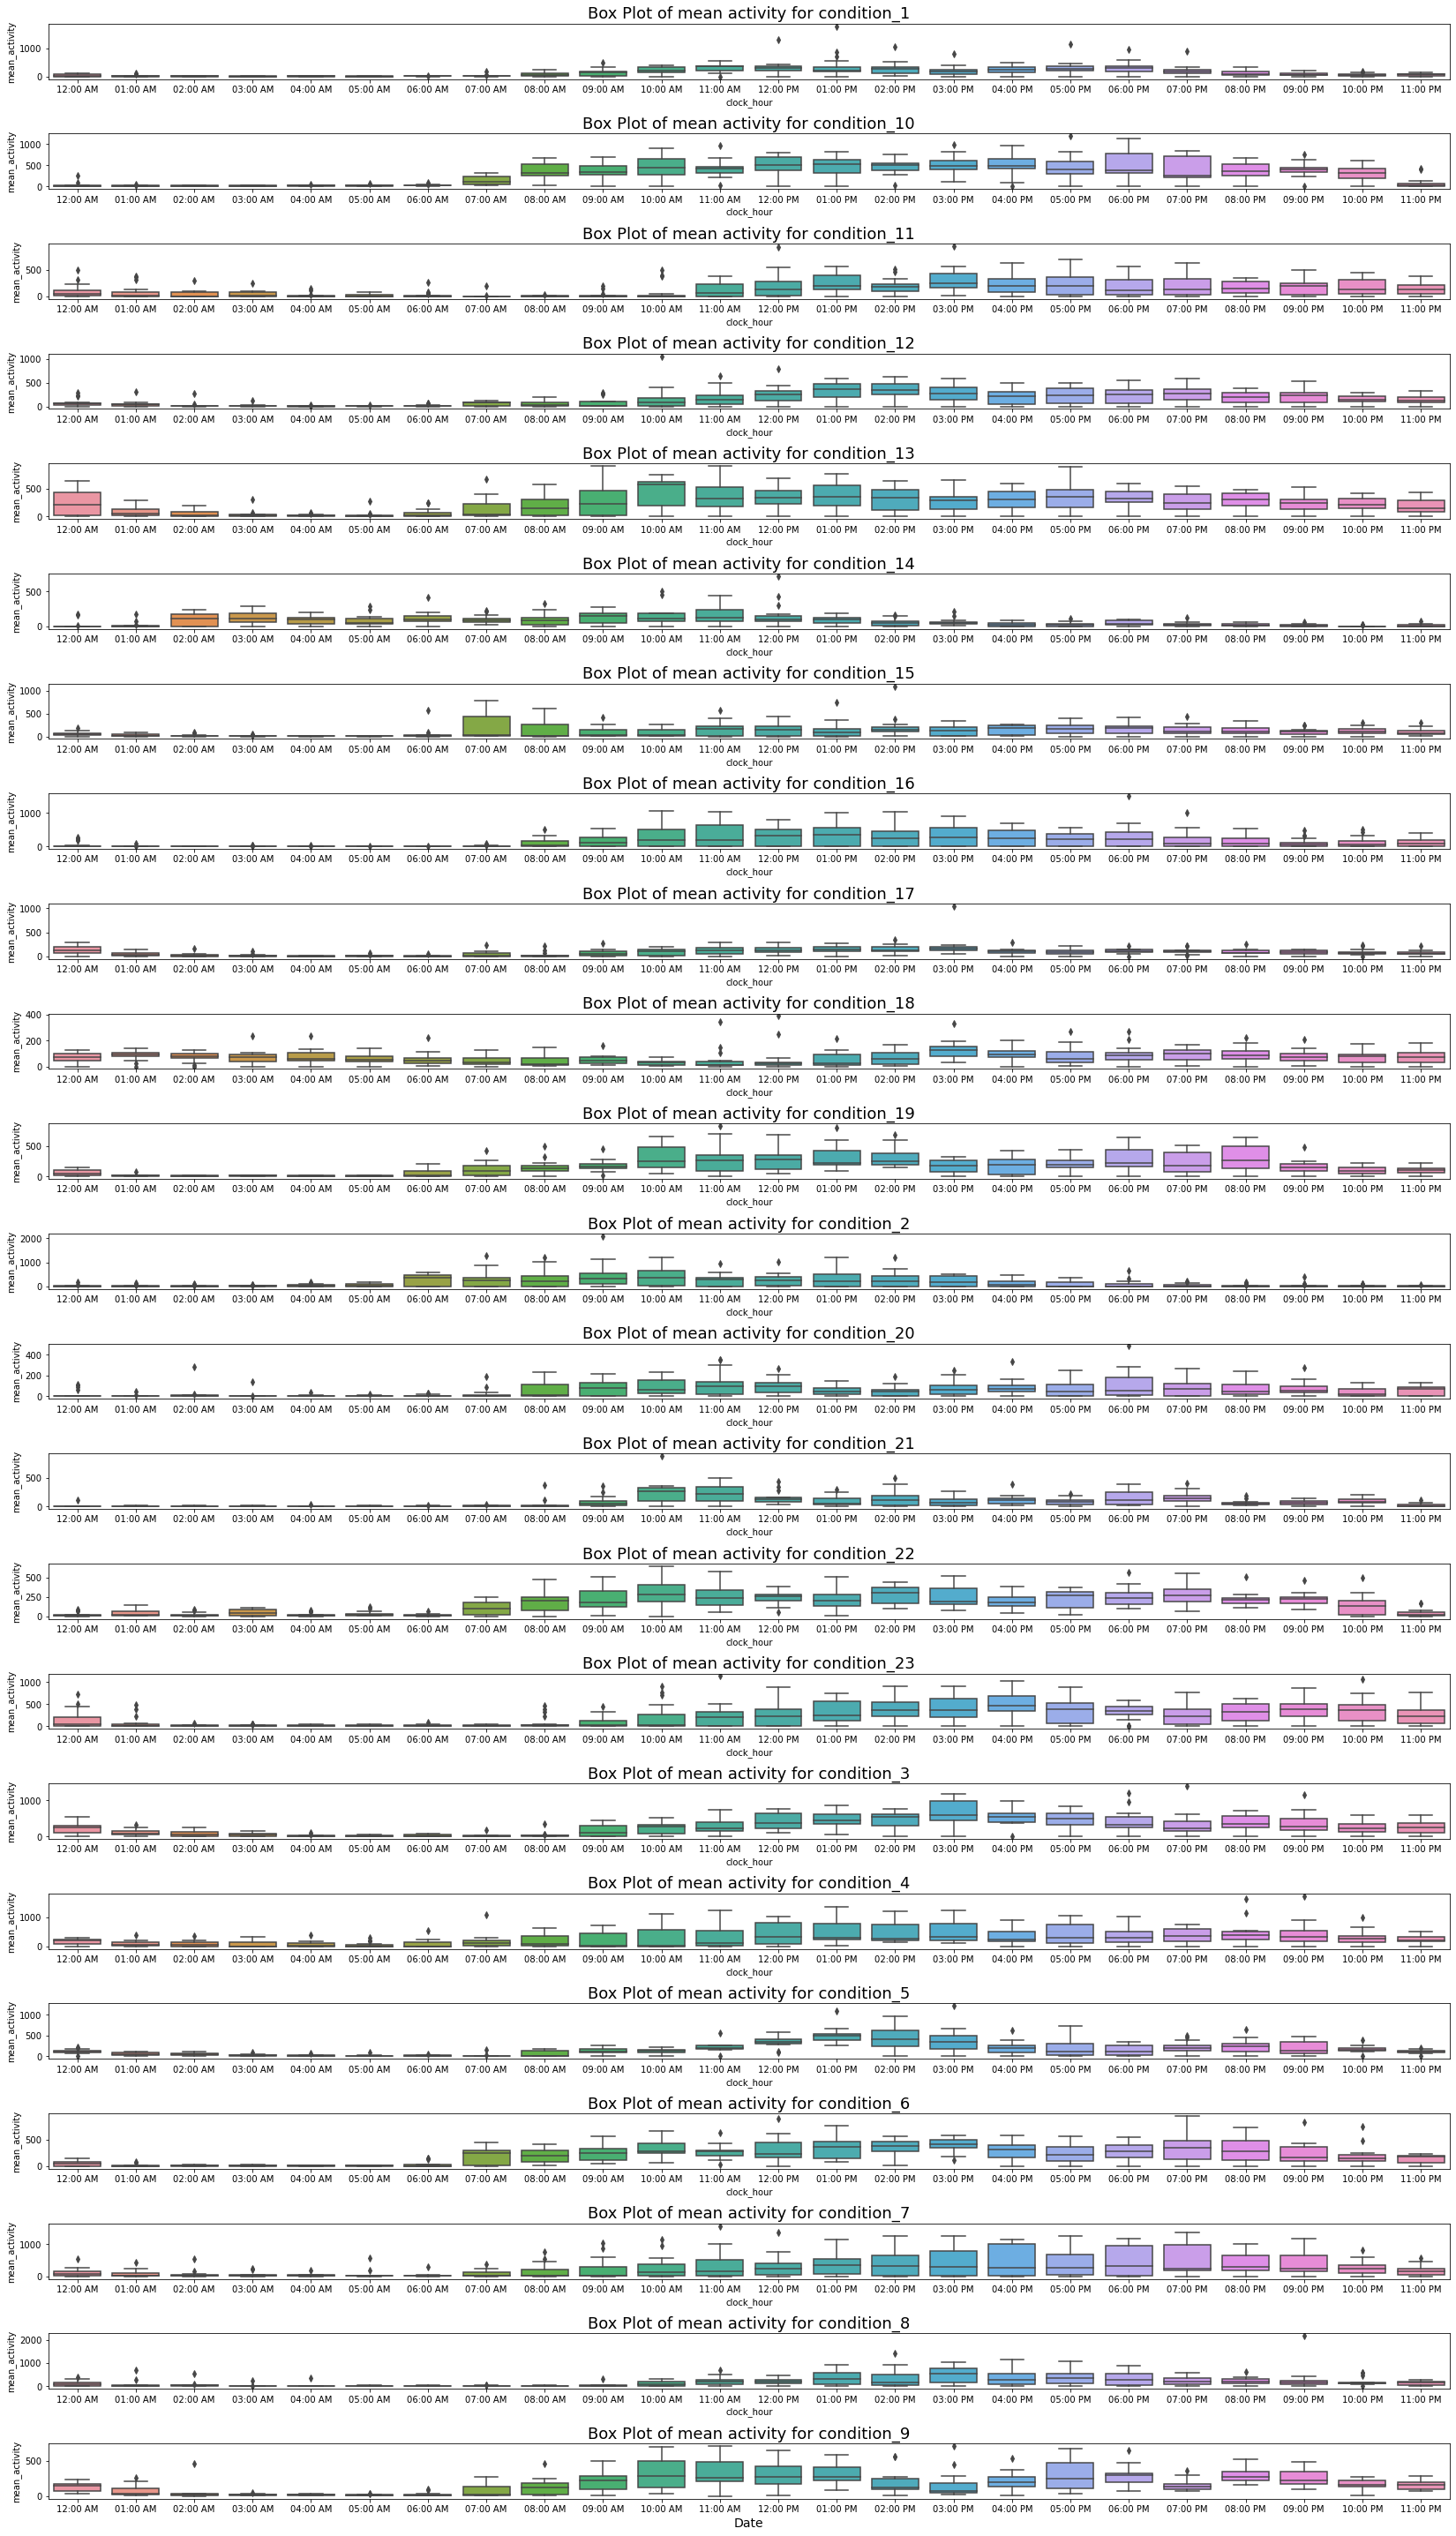

In [34]:
# Draw Plot
fig, axes = plt.subplots(23, 1, figsize=(23, 40))

cnt = 0
for i in range(23):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

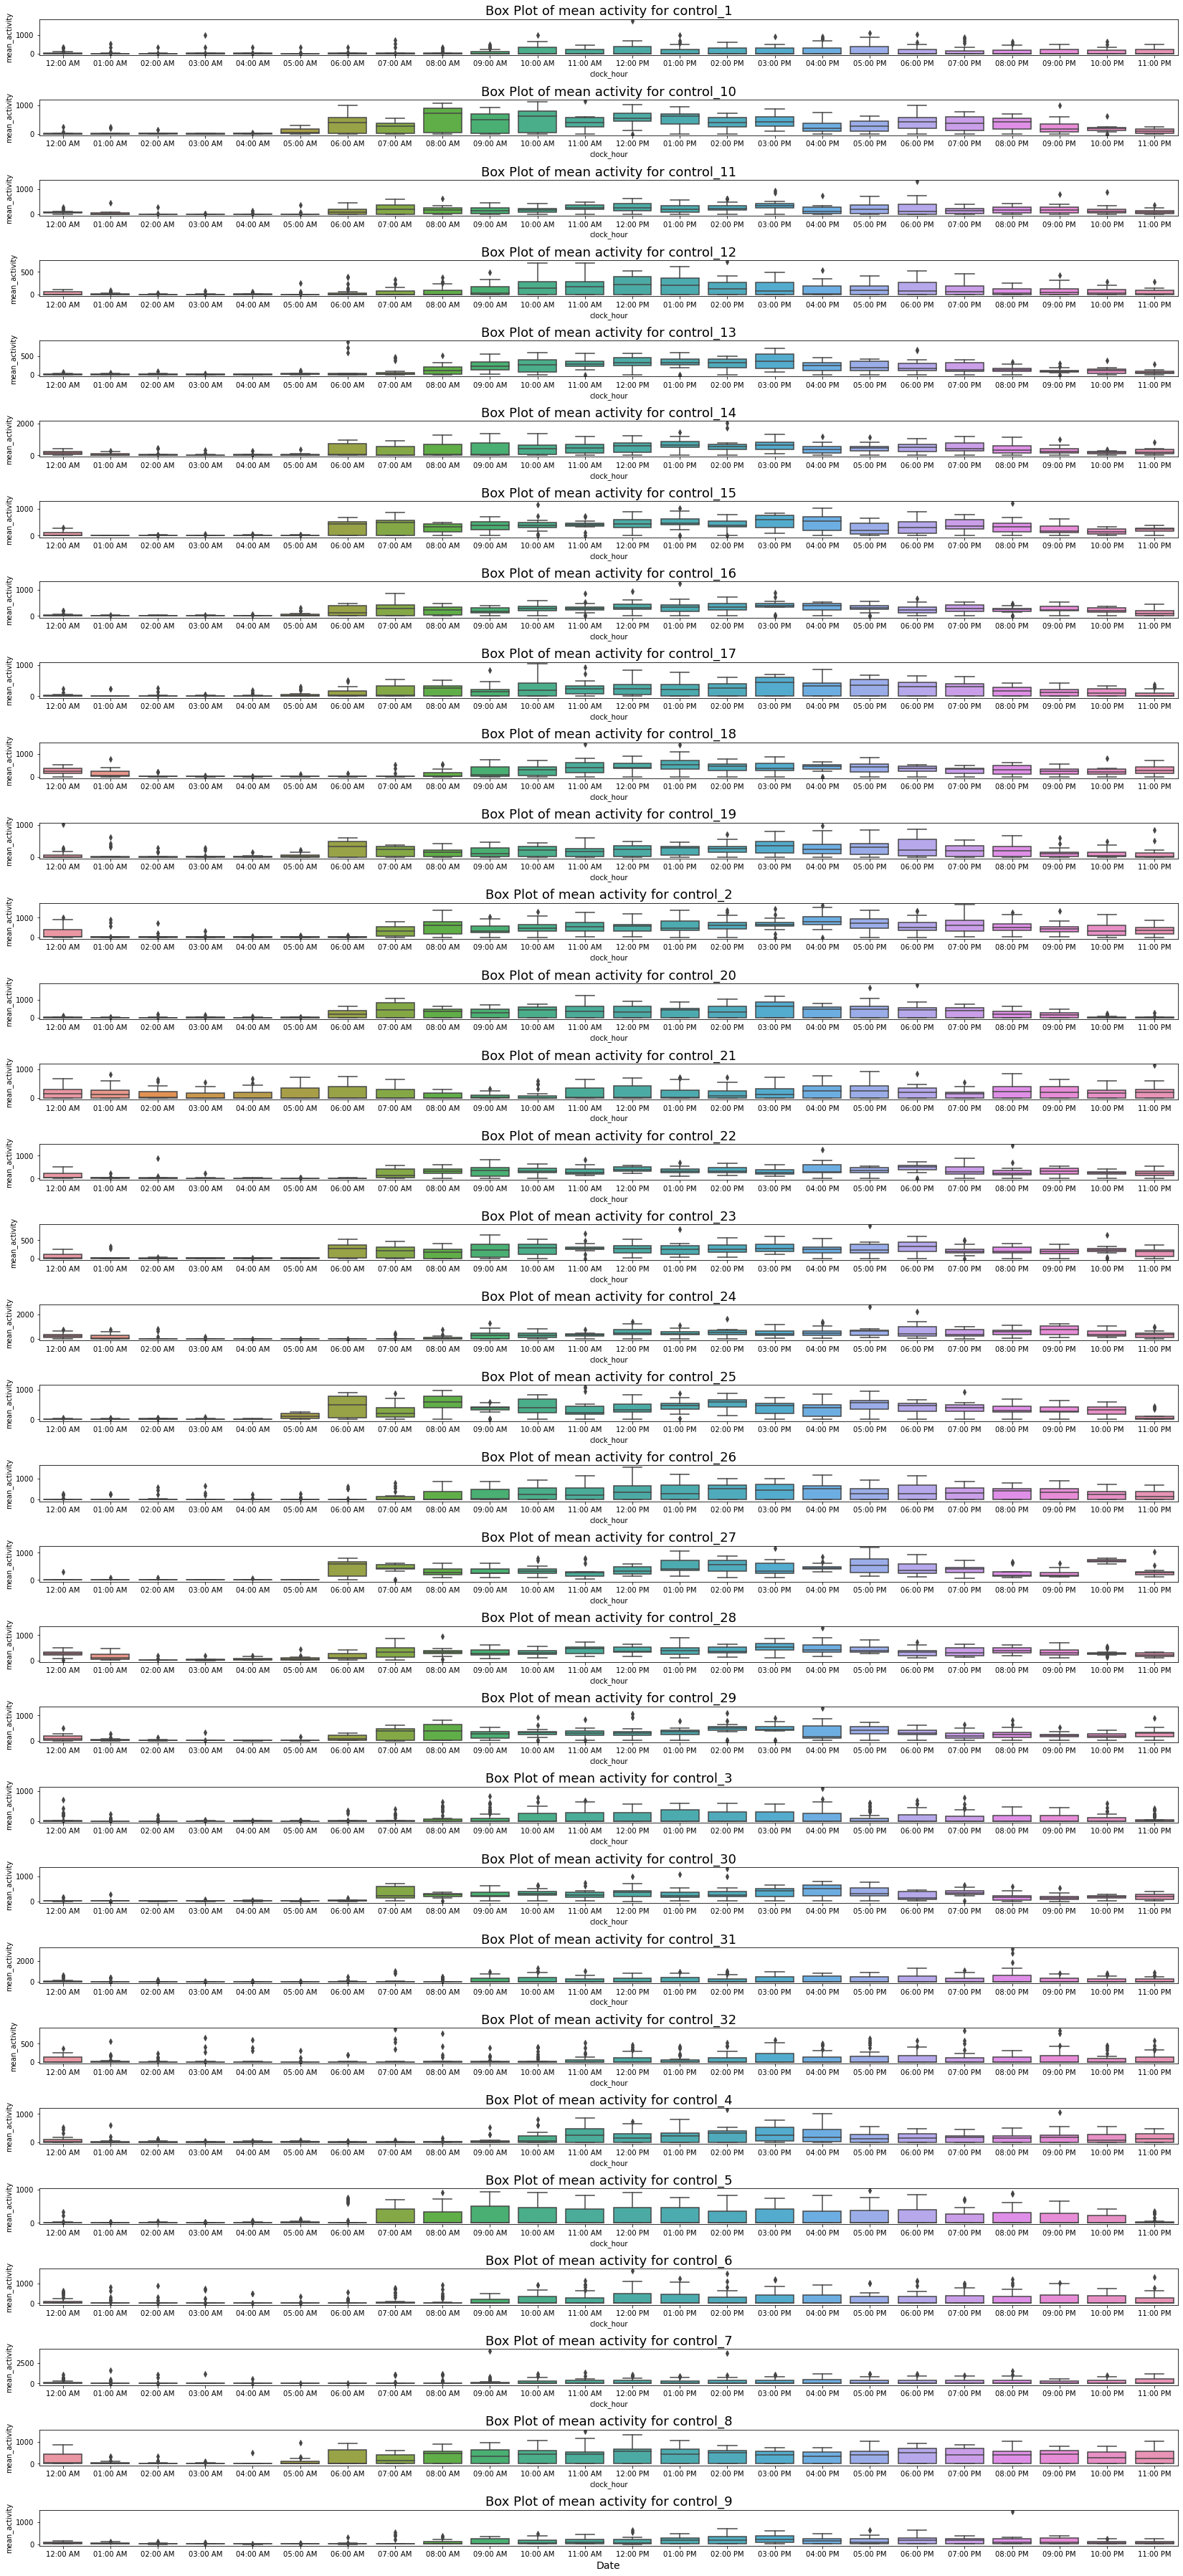

In [35]:
# Draw Plot
fig, axes = plt.subplots(32, 1, figsize=(23, 50))

cnt = 0
for i in range(32):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

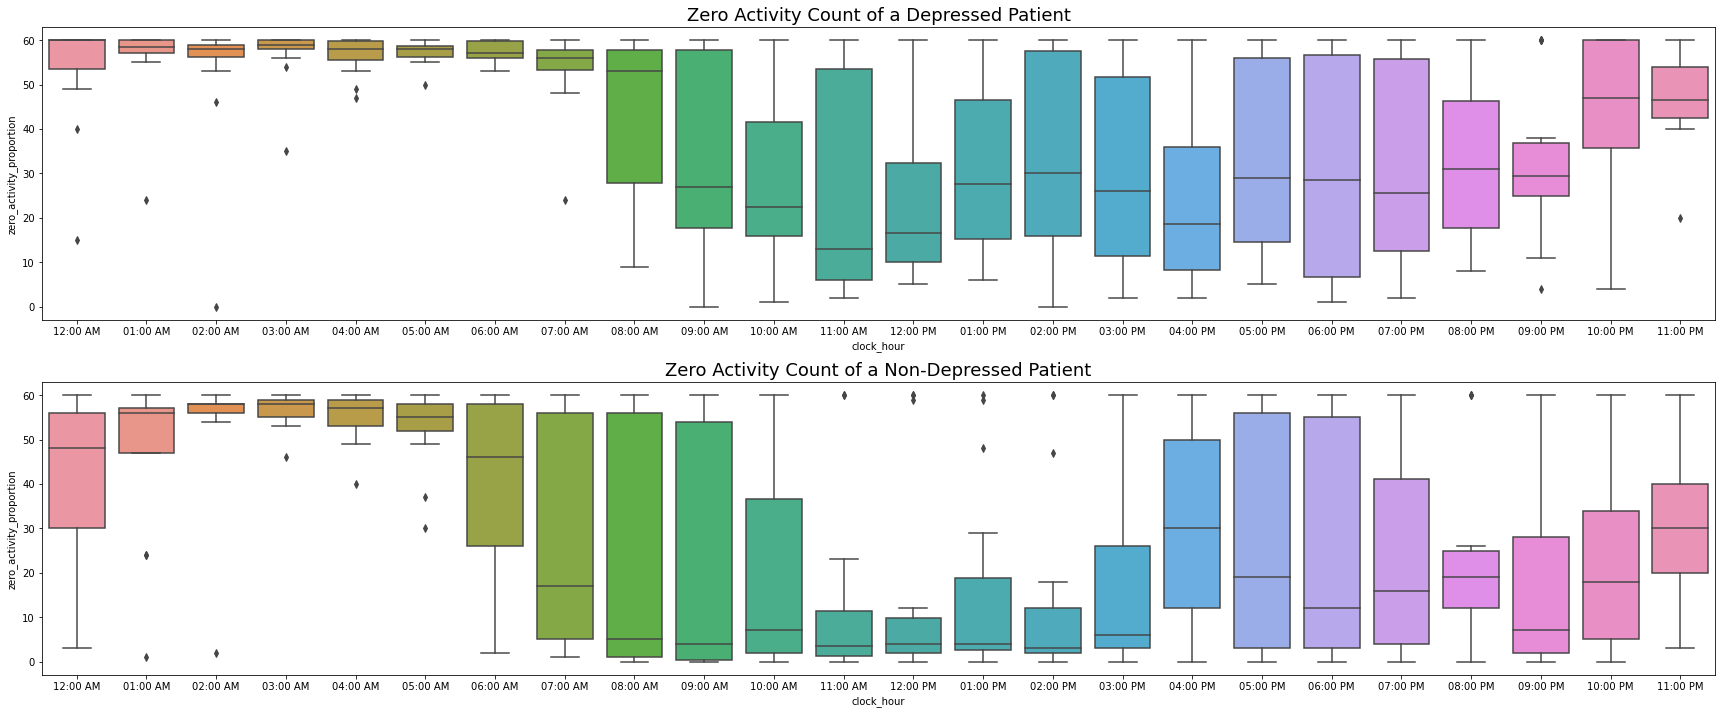

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

In [37]:
## Clustering Analysis

In [38]:
def nextday(dates):
    for date in dates:
        yield date

In [39]:
def zero_count(series):
    return list(series).count(0)

In [40]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [41]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)
                

        return pd.DataFrame(self.X)

In [42]:
e = ExtractData(path='C:\\Users\\yatha\\Downloads\\archive (6)\\data\\condition\\')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [43]:
conditions.tail()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
400,2.836361,2.604526,0.0,7.789869,578,condition_9,1
401,3.317860,2.664783,0.0,7.945201,491,condition_9,1
402,3.174113,2.653188,0.0,7.664816,505,condition_9,1
403,2.860525,2.617277,0.0,7.696213,572,condition_9,1
404,1.648750,2.476757,0.0,7.602900,596,condition_9,1


In [44]:
e = ExtractData(path='C:\\Users\\yatha\\Downloads\\archive (6)\\data\\control\\')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [45]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
0,4.269175,2.536873,0.0,7.758761,106,control_1,0
1,3.006935,2.636401,0.0,8.038512,557,control_1,0
2,3.220895,2.683718,0.0,7.883069,516,control_1,0
3,2.737783,2.699849,0.0,7.633854,657,control_1,0
4,3.302284,2.641430,0.0,7.789869,520,control_1,0


In [46]:
full_df.shape

(1144, 7)

In [47]:
full_df = full_df.sample(frac=1) # reshufle the dataset

In [48]:
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    
    return X_train, X_test, y_train, y_test

In [49]:
class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx , elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                    test_set.drop(['source'], axis=1))
            
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))

In [50]:
X = full_df.drop(['state'], axis=1)
y = full_df.state

In [50]:
pip install xgboost

In [51]:
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # Import Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier

In [52]:
   
forest = RandomForestClassifier(n_estimators=100)
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.88      0.65      0.75        43
           1       0.35      0.67      0.46        12

    accuracy                           0.65        55
   macro avg       0.61      0.66      0.60        55
weighted avg       0.76      0.65      0.68        55



In [ ]:
# forest = XGBClassifier(n_estimators=100)
# custom_clfCV = CustomClassifierCV(forest)
# custom_clfCV.fit(X, y)

In [59]:
forest = DecisionTreeClassifier()
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.84      0.69      0.76        39
           1       0.48      0.69      0.56        16

    accuracy                           0.69        55
   macro avg       0.66      0.69      0.66        55
weighted avg       0.74      0.69      0.70        55



In [67]:
#Calling the Class
naive_bayes = GaussianNB()
forest = naive_bayes
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.19      0.75      0.30         8
           1       0.91      0.45      0.60        47

    accuracy                           0.49        55
   macro avg       0.55      0.60      0.45        55
weighted avg       0.81      0.49      0.56        55



In [76]:
forest = LogisticRegression()
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.97      0.62      0.76        50
           1       0.17      0.80      0.29         5

    accuracy                           0.64        55
   macro avg       0.57      0.71      0.52        55
weighted avg       0.90      0.64      0.71        55



In [53]:
forest = KNeighborsClassifier()
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.91      0.67      0.77        43
           1       0.39      0.75      0.51        12

    accuracy                           0.69        55
   macro avg       0.65      0.71      0.64        55
weighted avg       0.79      0.69      0.72        55

